# Sentiment analysis: Amazon customer reviews
*Project by Monika Kaczan for the Text Mining & Social Media Mining class*

### Introduction

The goal of this project is to predict sentiment of a customer writing a review. The reviews concern Apple Iphone 11 and were published on the Amazon website. To predict the sentiment, we will use Naive Bayes Classification, VADER Score and two Neural Networks models: CBOW and LSTM. Then, based on ROC AUC score we will assess which model performed the best.

### Data

In this project I used Amazon reviews of Apple Iphone 11 (Renewed). The data was scraped from Amazon using apify scraper (https://apify.com/). This product was chosen due to a relative large number of reviews and their variety. Renewed means that phones are not new, but refurbished by Amazon and fully functional.

In [2]:
# Loading all nessesary libraries for the project.

import pandas as pd 
import numpy as np 
%matplotlib inline 
import seaborn as sns
import math
from langdetect import detect
#from textblob import TextBlob
import re

import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier

analyser = SentimentIntensityAnalyzer()

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
np.random.seed(1000)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils.np_utils import to_categorical

In [3]:
# Uploading the dataset

raw_data = pd.read_csv("dane_Amazon.csv")
print(raw_data)

             country  isVerified  position productAsin  ratingScore  \
0      United States        True         1  B07ZPKBL9V          5.0   
1      United States        True         2  B07ZPKBL9V          5.0   
2      United States        True         3  B07ZPKBL9V          5.0   
3      United States        True         4  B07ZPKBL9V          1.0   
4      United States        True         5  B07ZPKBL9V          2.0   
...              ...         ...       ...         ...          ...   
10936  United States        True      1836  B07ZPKR714          3.0   
10937  United States        True      1837  B07ZPKR714          1.0   
10938  United States        True      1838  B07ZPKR714          5.0   
10939  United States        True      1839  B07ZPKR714          5.0   
10940  United States        True      1840  B07ZPKR714          4.0   

                                       reviewDescription  \
0      The phone was in excellent condition and was e...   
1      It’s an awesome phon

In [4]:
# Deleting unnesseary columns 

df = raw_data.loc[:, ['position', 'ratingScore', 'reviewDescription', 'reviewTitle']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10941 entries, 0 to 10940
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   position           10941 non-null  int64  
 1   ratingScore        10941 non-null  float64
 2   reviewDescription  10855 non-null  object 
 3   reviewTitle        6970 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 342.0+ KB


In [5]:
# If reviewDescription is NaN, we take the reviewTitle as a full review. We also delete NaN rows.

df['reviewDescription'] = df.reviewDescription.fillna(df.reviewTitle)
df = df.drop('reviewTitle', axis = 1)
df = df.dropna(subset = ['reviewDescription', 'ratingScore'])
df.head(10)

,position,ratingScore,reviewDescription
0,1,5.0,The phone was in excellent condition and was e...
1,2,5.0,It’s an awesome phone good as new with 94% bat...
2,3,5.0,Ordered this phone as a replacement for my son...
3,4,1.0,Doesn't even deserve the 1-star . . . It took ...
4,5,2.0,It came with a little fail in the speaker. A l...
5,6,5.0,Even though it was refurbished everything work...
6,7,3.0,The phone doesn’t work so well it’s locked and...
7,8,3.0,Luckily my phone's battery was not too bad. Ov...
8,9,2.0,I bought this iPhone because it had great over...
9,10,5.0,Batería 99.9 todo nuevo me encanto nada de ray...


In [6]:
# Cleaning the text of reviews. Please note that we omit stemming and lemmatization as some of the methods we will use later 
# take into account full versions of particular words.

my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

def clean_review(review):
    
    review = review.lower() # lower case
    review = re.sub('['+my_punctuation + ']+', ' ', review) # strip punctuation
    review = re.sub('\s+', ' ', review) #remove double spacing
    review = re.sub('([0-9]+)', '', review) # remove numbers
    review = re.sub('(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])', '', review)
    return review

df['clean_review'] = df.reviewDescription.apply(clean_review)
df

,position,ratingScore,reviewDescription,clean_review
0,1,5.0,The phone was in excellent condition and was e...,the phone was in excellent condition and was e...
1,2,5.0,It’s an awesome phone good as new with 94% bat...,its an awesome phone good as new with battery...
2,3,5.0,Ordered this phone as a replacement for my son...,ordered this phone as a replacement for my son...
3,4,1.0,Doesn't even deserve the 1-star . . . It took ...,doesn t even deserve the star it took waaaayy...
4,5,2.0,It came with a little fail in the speaker. A l...,it came with a little fail in the speaker a li...
...,...,...,...,...
10936,1836,3.0,Eh. In my opinion,eh in my opinion
10937,1837,1.0,After about two months of use,after about two months of use
10938,1838,5.0,Phone in perfect conditions!! Very happy with ...,phone in perfect conditions very happy with my...
10939,1839,5.0,Very good,very good


In [7]:
# Reviews were written mainly in English, but there were also other languages present. We detect language so that we can later 
# focus only on reviews written in English.

# Additional function to handle exceptions
def f1(x):
    pom = x[0:100]
    try:
        return detect(pom)
    except:
        return 'error'
            
df['language'] = df['clean_review'].apply(lambda x: f1(x))
df['language'].value_counts()

en       8875
es        960
af        179
ro         99
so         93
fr         83
pt         80
ca         79
it         75
sl         71
no         55
cy         36
et         30
sq         29
tl         29
da         23
nl         22
error      18
pl         17
sk         16
sw         13
fi          8
id          7
hr          7
de          7
lv          7
sv          6
cs          5
tr          4
lt          2
hu          2
vi          1
Name: language, dtype: int64

In [8]:
df = df[df['language'] == 'en']

<AxesSubplot: xlabel='ratingScore'>

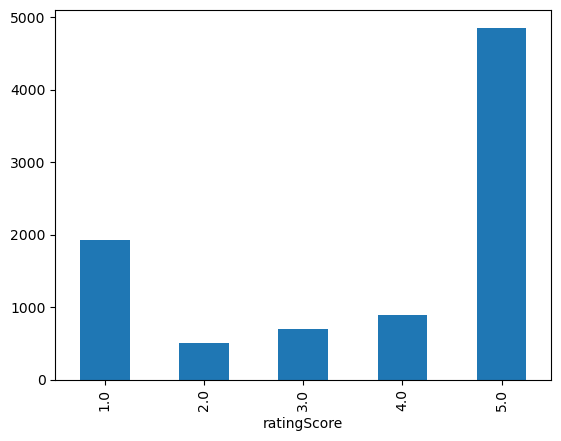

In [9]:
# Let's check how many stars were given for this products.

df.groupby('ratingScore').size().plot(kind='bar')

# We see that reviews are quite extreme - the most frequent rating was 5 stars and 1 star.

In this exercise we will consider only positive and negative sentiment. For 5 and 4 stars I will assign 'positive' sentiment, while 2 and 1 star will get 'negative' sentiment. This is due to the fact that 3 star reviews could be seen as positive, negative or neutral depending on the contex and assigning them only one label could be too much of a simplification.

In [10]:
# Deleting rows with 3star reviews and labeling sentiment. 

df.drop(df[df['ratingScore'] == 3].index, inplace = True)

# We have two identical colums with ratings only with different data types to simplify usage across different models. 

df['label'] = df['ratingScore'].apply(lambda x: 'positive' if x > 3 else 'negative')
df['label_int'] = df['ratingScore'].apply(lambda x: '1' if x > 3 else '0')

In [11]:
# For the analysis, we will only need selected columns. Here is our final dataset.

reviews = df.loc[:, ['position', 'clean_review', 'ratingScore', 'label', 'label_int']]
reviews.columns = ['id', 'text', 'score', 'label', 'label_int']
reviews = reviews.reset_index(drop = True)
reviews

,id,text,score,label,label_int
0,1,the phone was in excellent condition and was e...,5.0,positive,1
1,2,its an awesome phone good as new with battery...,5.0,positive,1
2,3,ordered this phone as a replacement for my son...,5.0,positive,1
3,4,doesn t even deserve the star it took waaaayy...,1.0,negative,0
4,5,it came with a little fail in the speaker a li...,2.0,negative,0
...,...,...,...,...,...
8172,1833,i love everything about this product and im no...,5.0,positive,1
8173,1834,i simply love this phone i would have gave the...,5.0,positive,1
8174,1837,after about two months of use,1.0,negative,0
8175,1838,phone in perfect conditions very happy with my...,5.0,positive,1


### Preliminary analysis

In [11]:
from wordcloud import WordCloud,STOPWORDS

import nltk.corpus
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.corpus import stopwords 

import nltk
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 

In [12]:
# Exploting structure of the dataset.

reviews['label'].value_counts()

positive    5758
negative    2430
Name: label, dtype: int64

We have 8170 reviews, including 5746 classified as positive and 2424 classified as negative. We can say that our data is slightly imbalanced. Therefore as performance measures for our models we will use ROC AUC score (similiar to balanced accuracy). 

In [13]:
# Creating wordclouds for postive and negative reviews to visually represent distribution of words.

reviews_positive = reviews[reviews['label_int'] == '1']
reviews_negative = reviews[reviews['label_int'] == '0']
                            
words_positive = ' '.join(reviews_positive['text'])
cleaned_words_positive = " ".join([word for word in words_positive.split()])

words_negative = ' '.join(reviews_negative['text'])
cleaned_words_negative = " ".join([word for word in words_negative.split()])

stopwords = set(STOPWORDS)
stopwords.update(["iPhone", "phone", "s", "Apple", "purchase", "will", "Amazon", "came", 'm'])

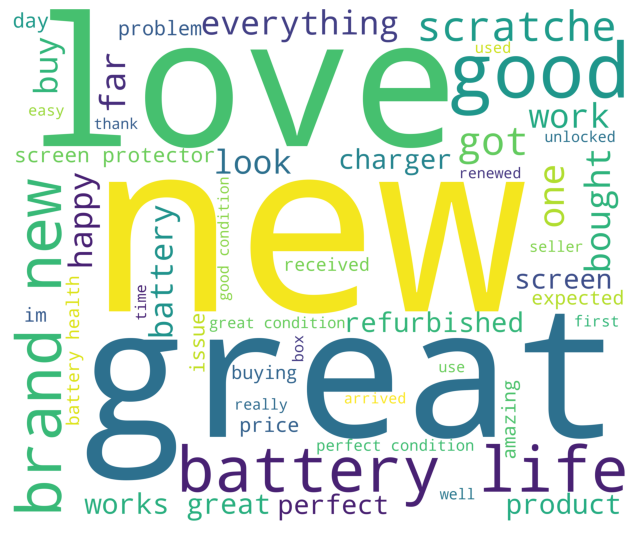

In [14]:
wordcloud_positive = WordCloud(stopwords = stopwords,
                      background_color = 'white',
                      width = 3000,
                      height = 2500,
                      max_words = 50,
                      ).generate(cleaned_words_positive)

plt.figure(1, figsize = (8, 8))
plt.imshow(wordcloud_positive)
plt.axis('off')
plt.show()

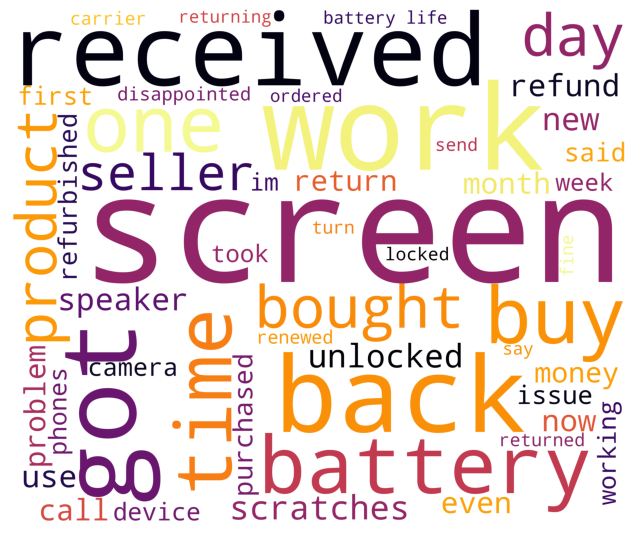

In [15]:
wordcloud_negative = WordCloud(stopwords = stopwords,
                          background_color = 'white',
                          width = 3000,
                          height = 2500,
                          max_words = 50,
                          colormap = 'inferno'     
                          ).generate(cleaned_words_negative)

plt.figure(1, figsize = (8, 8))
plt.imshow(wordcloud_negative)
plt.axis('off')
plt.show()

We see that most popular words in positive and negative reviews vary significantly. Positive ones focus on 'good' words such as 'great', 'new', 'love'. Negative reviews often refer to various problems such as 'scratches' and 'refund' or point out particular (possibly not working) functions like 'battery' or 'screen'.

### Sentiment analysis

Sentiment analysis is a method of analyzing text data in order to identify its intent. As mentioned above, in this project we will try to predict whether the sentiment of a person writing the review was positive or negative.

#### Naive Bayes Classification

Naive Bayes Classification is a probabilistic classifier. It calculates the probability of each tag for a given text and then output the tag with the highest probability.

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import naive_bayes, metrics
from sklearn.metrics import accuracy_score

In [17]:
# First we split reviews into training and testing samples 75% to 25%.

training_reviews = reviews.sample(frac = 0.75, random_state=1000)
testing_reviews = reviews.drop(training_reviews.index)

In [18]:
# We separate vectors of target variable - labels (positive or negative) and text of reviews as features

train_y = training_reviews['label'].values 
train_text = training_reviews['text'].values

test_y = testing_reviews['label'].values
test_text = testing_reviews['text'].values

In [19]:
# Tranforming labels to numbers to use in the model

label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_y)
test_y = label_encoder.fit_transform(test_y)

In [20]:
# We extract features from the text and turn those into vectors that can be understood by the model.

count_vector = CountVectorizer(analyzer='word', token_pattern = r'\w{1,}')
count_vector.fit(reviews['text'])

x_train_count = count_vector.transform(train_text)
x_valid_count = count_vector.transform(test_text)

In [21]:
classifier = naive_bayes.MultinomialNB()
classifier.fit(x_train_count, train_y)

fitted = classifier.predict(x_train_count)
predictions = classifier.predict(x_valid_count)

In [22]:
print("ROC AUC score on training data:", roc_auc_score(fitted, train_y))
print("ROC AUC score on testing data:", roc_auc_score(predictions, test_y))

ROC AUC score on training data: 0.8985120666211088
ROC AUC score on testing data: 0.8945124081640576


We see that Naive Bayes Classification ROC AUC scores are very high, both on training and testing data. These scores are quite similiar so there is no significant overfitting effect.

#### VADER

VADER is a valence based sentyment analyzer. It takes into account the "intensity" of a word as opposed to only the polarity. Suggested scale is positive for compound value >= 0.5, negative for <= -0.5 and neutral for anything in between. Here we took 0 as a cut-off point between positive and negative sentiment. We also did not split the sample on testing and training data, although in further analysis one might try to optimize for example cut off points for compound values. 

In [23]:
# We can try to calculate the VADER score for the first review to test it.

print(reviews.iloc[1]['text'])
print(analyser.polarity_scores(reviews.iloc[1]['text']))

# The compound score is 0.9392 which would be classified as (high) positive. For this example it is correct. 

its an awesome phone good as new with  battery life
{'neg': 0.0, 'neu': 0.533, 'pos': 0.467, 'compound': 0.7906}


In [26]:
predicted_value = [ ]
i = 0

while(i < len(reviews)):
    if (reviews.iloc[i]['VADER score'] >= 0):
        predicted_value.append('1')
    else:
        predicted_value.append('0')
    i = i+1
        
reviews['VADER predicted'] = predicted_value

In [27]:
reviews

,id,text,score,label,label_int,VADER score,VADER predicted
0,1,the phone was in excellent condition and was e...,5.0,positive,1,0.7650,1
1,2,its an awesome phone good as new with battery...,5.0,positive,1,0.7906,1
2,3,ordered this phone as a replacement for my son...,5.0,positive,1,-0.0498,0
3,4,doesn t even deserve the star it took waaaayy...,1.0,negative,0,0.0000,1
4,5,it came with a little fail in the speaker a li...,2.0,negative,0,-0.5594,0
...,...,...,...,...,...,...,...
8183,1833,i love everything about this product and im no...,5.0,positive,1,0.8589,1
8184,1834,i simply love this phone i would have gave the...,5.0,positive,1,0.3818,1
8185,1837,after about two months of use,1.0,negative,0,0.0000,1
8186,1838,phone in perfect conditions very happy with my...,5.0,positive,1,0.8268,1


In [28]:
print("ROC AUC score:", roc_auc_score(reviews['label_int'].values, reviews['VADER predicted'].values))

ROC AUC score: 0.6617148158153909


ROC AUC score isn't very good. It is ignificantly lower compared to training and testing data in Naive Bayes Classification. Let's investigate the incorrect predictions a little further.

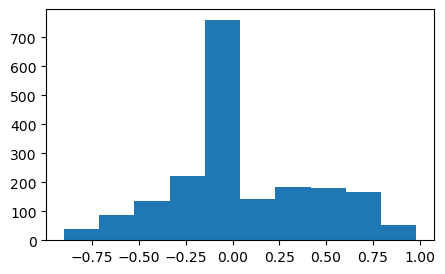

In [29]:
didntmakeit = reviews[reviews['label_int'] != reviews['VADER predicted']]
didntmakeit.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize =(5, 3))
ax.hist(didntmakeit['VADER score'])
plt.show()

We see that many reviews incorrectly classified had VADER score close to 0, or in the (-0.5, 0.5) range which suggest that their contains were classified as neutral which label we did not have. However, it is still rather unlikely that such a large fraction of - after all very high or very low (5s, 4s, 2s and 1s) - scores contained this many neutral entries. We can conclude that VADER simply performs worse than other methods.

#### Neural Networks - CBOW model

Although our data sample is quite small, we can also try to build neural networks. We firstly try CBOW (Continuous Bag Of Words) model which predicts the current word given the context of words within a specific window.


In [30]:
# We again create variables with training and testing samples from the same random seed.

training_reviews = reviews.sample(frac = 0.75, random_state=1000)
testing_reviews = reviews.drop(training_reviews.index)

train_y = training_reviews['label_int'].values 
train_text = training_reviews['text'].values

test_y = testing_reviews['label_int'].values
test_text = testing_reviews['text'].values

In [31]:
# First, we will preprocess text for the (supervised) CBOW model.

# Size of the vocabulary
MAX_NB_WORDS = 5000

# Getting the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# Vectorizing the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words = MAX_NB_WORDS, char_level = False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3656 unique tokens.


In [32]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [33]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 21.5
max length: 285


(array([1.426e+03, 1.393e+03, 8.720e+02, 5.360e+02, 4.740e+02, 3.540e+02,
        2.060e+02, 2.170e+02, 1.650e+02, 9.800e+01, 9.600e+01, 7.200e+01,
        3.600e+01, 3.200e+01, 2.700e+01, 3.200e+01, 1.600e+01, 1.700e+01,
        6.000e+00, 1.500e+01, 8.000e+00, 1.200e+01, 5.000e+00, 3.000e+00,
        5.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([  1.  ,   6.68,  12.36,  18.04,  23.72,  29.4 ,  35.08,  40.76,
         46.44,  52.12,  57.8 ,  63.48,  69.16,  74.84,  80.52,  86.2 ,
         91.88,  97.56, 103.24, 108.92, 114.6 , 120.28, 125.96, 131.64,
        137.32, 143.  , 148.68, 154.36, 160.04, 165.72, 171.4 , 177.08,
        182.76, 188.44, 194.12, 199.8 , 205.48, 211.16, 216.84, 222.52,
        228.2 , 

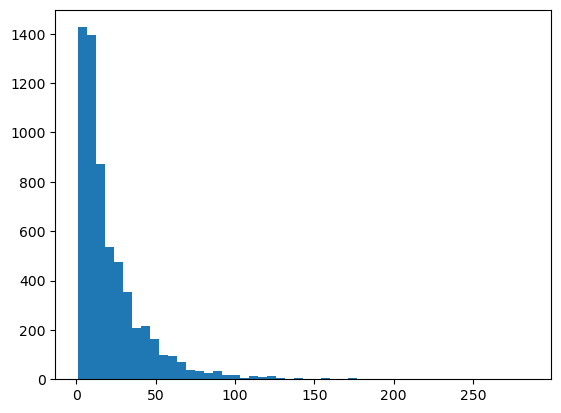

In [34]:
# What input sequence to the embedding layer will be enough?

%matplotlib inline
plt.hist(seq_lens, bins = 50)

In [35]:
# Based on the graph above, I believe that the maximum sequence lenght to the embedding layer of 125 will be sufficient.

MAX_SEQUENCE_LENGTH = 125

# We pad sequences with 0s so all of them are the lenght of 125.

x_train = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (6141, 125)
Shape of data test tensor: (2047, 125)


In [36]:
y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (6141, 2)


In [37]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50 # Length of the vector for each word
N_CLASSES = 2

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length = MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [38]:
# We will train model with 100 epochs.

model.fit(x_train, y_train, validation_split = 0.1, epochs = 100, batch_size = 128, verbose = 0)

In [39]:
output_test = model.predict(x_test)
print("ROC AUC score on testing data:", roc_auc_score(y_test, output_test[:,1]))

64/64 [==============================] - 0s 1ms/step
ROC AUC score on testing data: 0.970039867626155


Using CBOW model we achieved an exeptionally high ROC AUC score on testing sample which means that our model performs really well.

#### Neural Networks - LSTM 

We also tried a more complex algorithm called LSTM (Long-Short Term Memory). It is a type of recurrent neural network algorithm which means that it uses sequential data It efficiently improves performance by memorizing the relevant information that is important and finds the pattern.

In [40]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout = 0.2, recurrent_dropout = 0.2)(embedded_sequences)
predictions = Dense(2, activation='softmax')(x)

model2 = Model(sequence_input, predictions)
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [41]:
# We will train model with 50 epochs.

model2.fit(x_train, y_train, validation_split = 0.1, epochs = 50, batch_size = 128, verbose = 0)

In [42]:
output_test2 = model2.predict(x_test)
print("ROC AUC score on testing data::", roc_auc_score(y_test, output_test2[:,1]))

64/64 [==============================] - 4s 55ms/step
ROC AUC score on testing data:: 0.9581523187633262


We again achieved a very high ROC AUC score. It is a little lower but comparable with the one achieved by CBOW model. The difference could be due e.g. lower number of epochs (here I choose 50 epochs because of longer processing time).

## Summary & conclusions

In this project we analyzed sentiment of Amazon customers who were reviewing iPhone 11. 

Preliminary analysis of word frequencies (wordcloud) revealed that positive and negative reviews were characterized by significantly different words. 

Next, we compared results of sentiment analysis conducted by four methods: Naive Bayes Classification, VADER score and neural networks: CBOW and LSTM. The best performing models by a far margin were those based on neural networks, with CBOW performing slightly better than LSTM. The ROC AUC scores of both models were around 0.97. Naive Bayes Classification achieved ROC AUC score of 0.87. The worst was model based on VADER with ROC AUC score of only 0.66.